# Covid-19 Time Series Modeling

- Flex
- Instructor: Morgan Jones
- Blog: 
- Date of Review:

# Abstract

# Introduction

## The Business Problem

- Covid-19 Epidemic

##  This Project | The Business + Business Problem

- company akin to WHO --> create time series model of the epidemic to forcast 

## The Data Source
 - git hub read me description --> https://github.com/owid/covid-19-data/blob/master/public/data/README.md
 
 - Our World in Data [Kaggle](https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset)
 
 - Our World in Data, original site --> https://ourworldindata.org/explorers/coronavirus-data-explorer
 
 - WHO data

### Reproducing via Google CoLabs

- detailed instructions on how to download AND
- write script to download data from source(s)

In [21]:
# Import Needed Libraries

import json
import shutil
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [2]:
# Versions
import sys
import matplotlib

print('Python | ', sys.version[:5])
print('Pandas | ', pd.__version__)
print('Numpy | ', np.__version__)
print('Matplotlib | ', matplotlib.__version__)
print('Seaborn | ', sns.__version__)
print('Geopandas | ', gpd.__version__)

Python |  3.8.5
Pandas |  1.1.3
Numpy |  1.18.5
Matplotlib |  3.3.1
Seaborn |  0.11.0
Geopandas |  0.13.2


In [ ]:
# Prep Google CoLab environment to download data from Kaggle
#!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json

#username = ''  ## Your Kaggle username
#api_key = ''  ## Your Kaggle API key

#api_token = {"username": username,
#             "key": api_key}

#with open('/root/.kaggle/kaggle.json', 'w') as file:
#    json.dump(api_token, file)

#!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset from Kaggle
#!kaggle datasets download -d caesarmario/our-world-in-data-covid19-dataset
#!kaggle datasets download -d paultimothymooney/latitude-and-longitude-for-every-country-and-state

In [ ]:
# This cell unzips the downloaded data
#shutil.unpack_archive('our-world-in-data-covid19-dataset.zip', '/content')
#shutil.unpack_archive('latitude-and-longitude-for-every-country-and-state.zip', '/content')

# Data Exploration

- what data are we working with?
- columns? which ones keep/disregard + why?
- what is business prob? need to modify data in any way to address this?
- look for trends + seasonality
- look for key 'turning points' --> when vaccine was released 
    - provide supporting evidence here if needed
- other descriptive statistics for a feel of what data we are working with
    - graphs of data over time (deaths, confirmed cases, recovered, vaccinated)
    - histograms?
    - visual of data on country or region basis?

In [3]:
df = pd.read_csv('owid-covid-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350085 entries, 0 to 350084
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    350085 non-null  object 
 1   continent                                   333420 non-null  object 
 2   location                                    350085 non-null  object 
 3   date                                        350085 non-null  object 
 4   total_cases                                 312088 non-null  float64
 5   new_cases                                   340457 non-null  float64
 6   new_cases_smoothed                          339198 non-null  float64
 7   total_deaths                                290501 non-null  float64
 8   new_deaths                                  340511 non-null  float64
 9   new_deaths_smoothed                         339281 non-null  float64
 


| Columns | Description | 
|:--|:--| 
| `continent` | Continent of the geographical location | 
| `location` | Geographical location | 
| `date` | Date of observation | 
| `new_cases` | New confirmed cases of COVID-19. Counts can include probable cases, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA | 
| `new_cases_smoothed` | New confirmed cases of COVID-19 (7-day smoothed). Counts can include probable cases, where reported. | 
| `new_deaths` | New deaths attributed to COVID-19. Counts can include probable deaths, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA. |
| `new_deaths_smoothed` | New deaths attributed to COVID-19 (7-day smoothed). Counts can include probable deaths, where reported. |
| `reproduction_rate` | Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database | 
| `icu_patients` | Number of COVID-19 patients in intensive care units (ICUs) on a given day. |
| `hosp_patients` | Number of COVID-19 patients in hospital on a given day. |
| `new_tests` | New tests for COVID-19 (only calculated for consecutive days). |
| `new_tests_smoothed` | New tests for COVID-19 (7-day smoothed). For countries that don't report testing data on a daily basis, we assume that testing changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window |
| `positive_rate` | The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case). |
| `test_units` | Units used by the location to report its testing data. A country file can't contain mixed units. All metrics concerning testing data use the specified test unit. Valid units are 'people tested' (number of people tested), 'tests performed' (number of tests performed. a single person can be tested more than once in a given day) and 'samples tested' (number of samples tested. In some cases, more than one sample may be required to perform a given test.) | 
| `people_vaccinated` | Total number of people who received at least one vaccine dose | 
| `new_people_vaccinated_smoothed` | Daily number of people receiving their first vaccine dose (7-day smoothed) | 
| `new_vaccinations` | New COVID-19 vaccination doses administered (only calculated for consecutive days) | 
| `new_vaccinations_smoothed` | New COVID-19 vaccination doses administered (7-day smoothed). For countries that don't report vaccination data on a daily basis, we assume that vaccination changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window |
| `total_boosters` | Total number of COVID-19 vaccination booster doses administered (doses administered beyond the number prescribed by the vaccination protocol) |
| `stringency_index` | Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response). | 
| `population_density` | Number of people divided by land area, measured in square kilometers, most recent year available | 
| `median_age` | Median age of the population, UN projection for 2020 | 
| `aged_70_older` | Share of the population that is 70 years and older in 2015 |
| `gdp_per_capita` | Gross domestic product at purchasing power parity (constant 2011 international dollars), most recent year available | 
| `extreme_poverty` | Share of the population living in extreme poverty, most recent year available since 2010 | 
| `cardiovasc_death_rate` | Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people) | 
| `diabetes_prevalence` | Dabetes prevalence (% of population aged 20 to 79) in 2017 |
| `female_smokers` | Share of women who smoke, most recent year available | 
| `male_smokers` | Share of men who smoke, most recent year available | 
| `handwashing_facilities` | Share of the population with basic handwashing facilities on premises, most recent year available |
| `hospital_beds_per_thousand` | Hospital beds per 1,000 people, most recent year available since 2010 |
| `life_expectancy` | Life expectancy at birth in 2019 | 
| `human_development_index` | A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506 | 
| `population` | Population (latest available values). See https://github.com/owid/covid-19-data/blob/master/scripts/input/un/population_latest.csv for full list of sources | 



In [4]:
# Choose which columns to use/drop
cols_to_use = ['continent', 'location', 'date', 'new_cases_smoothed', 'new_deaths_smoothed',
               'reproduction_rate', 'icu_patients', 'hosp_patients', 'new_tests_smoothed', 
               'positive_rate', 'tests_units', 'people_vaccinated', 'new_people_vaccinated_smoothed',
               'total_boosters', 'new_vaccinations_smoothed', 'stringency_index', 'population_density', 
               'median_age', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
               'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 
               'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'population']
df1 = df[cols_to_use]

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350085 entries, 0 to 350084
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   continent                       333420 non-null  object 
 1   location                        350085 non-null  object 
 2   date                            350085 non-null  object 
 3   new_cases_smoothed              339198 non-null  float64
 4   new_deaths_smoothed             339281 non-null  float64
 5   reproduction_rate               184817 non-null  float64
 6   icu_patients                    37615 non-null   float64
 7   hosp_patients                   38902 non-null   float64
 8   new_tests_smoothed              103965 non-null  float64
 9   positive_rate                   95927 non-null   float64
 10  tests_units                     106788 non-null  object 
 11  people_vaccinated               75911 non-null   float64
 12  new_people_vacci

In [6]:
df1['date'] = pd.to_datetime(df1['date'])

<ipython-input-6-e448b256dc75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.to_datetime(df1['date'])


In [7]:
lat_long = pd.read_csv('world_country_and_usa_states_latitude_and_longitude_values.csv')
lat_long = lat_long[['latitude', 'longitude', 'country']]
lat_long.head()

,latitude,longitude,country
0,42.546245,1.601554,Andorra
1,23.424076,53.847818,United Arab Emirates
2,33.939110,67.709953,Afghanistan
3,17.060816,-61.796428,Antigua and Barbuda
4,18.220554,-63.068615,Anguilla


In [8]:
df2 = pd.merge(df1,
              lat_long,
              left_on='location',
              right_on='country',
              how='left')

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350085 entries, 0 to 350084
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   continent                       333420 non-null  object        
 1   location                        350085 non-null  object        
 2   date                            350085 non-null  datetime64[ns]
 3   new_cases_smoothed              339198 non-null  float64       
 4   new_deaths_smoothed             339281 non-null  float64       
 5   reproduction_rate               184817 non-null  float64       
 6   icu_patients                    37615 non-null   float64       
 7   hosp_patients                   38902 non-null   float64       
 8   new_tests_smoothed              103965 non-null  float64       
 9   positive_rate                   95927 non-null   float64       
 10  tests_units                     106788 non-null  object 

In [10]:
# Drop not countries
loc_to_drop = ['Africa', 'Asia', 'Europe', 'European Union', 'High income', 
               'Low income', 'Lower middle income', 'North America', 'Oceania', 
               'South America', 'Upper middle income', 'World']

df2 = df2[~df2['location'].isin(loc_to_drop)]

<ipython-input-11-60455037b984>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


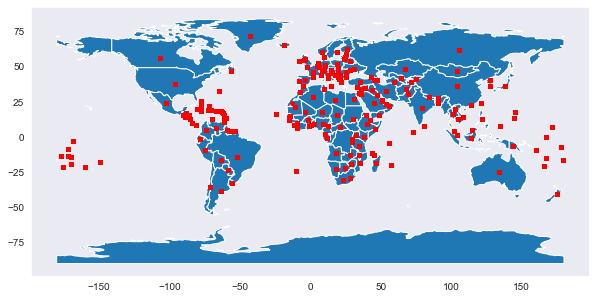

In [11]:
# https://stackoverflow.com/a/53233489

geometry = [Point(xy) for xy in zip(df2['longitude'], df2['latitude'])]
gdf = GeoDataFrame(df2[['longitude', 'latitude']], geometry=geometry)   

# this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Talk about choice here to use the different continents as the different zones based off map -- countries in which we have data points from.

In [12]:
# Drop non-countries from df1
df1 = df1[~df1['location'].isin(loc_to_drop)]

In [13]:
df1['continent'].isna().sum()

0

In [14]:
df1['continent'].unique()

array(['Asia', 'Europe', 'Africa', 'Oceania', 'North America',
       'South America'], dtype=object)

In [50]:
# Create the different dataframes that we will use for modeling

df_asia = df1[df1['continent'] == 'Asia']
df_eu = df1[df1['continent'] == 'Europe']
df_af = df1[df1['continent'] == 'Africa']
df_oc = df1[df1['continent'] == 'Oceania']
df_na = df1[df1['continent'] == 'North America']
df_sa = df1[df1['continent'] == 'South America']

In [43]:
data = [('Asia', df_asia), ('Europe', df_eu), ('Africa', df_af), 
        ('Oceana', df_oc), ('North America', df_na), ('South America', df_sa)]

for (name, df) in data:
    nulls = df.isna().sum().sum()
    print(name, nulls)

Asia 610565
Europe 764416
Africa 759079
Oceana 515862
North America 792359
South America 185857


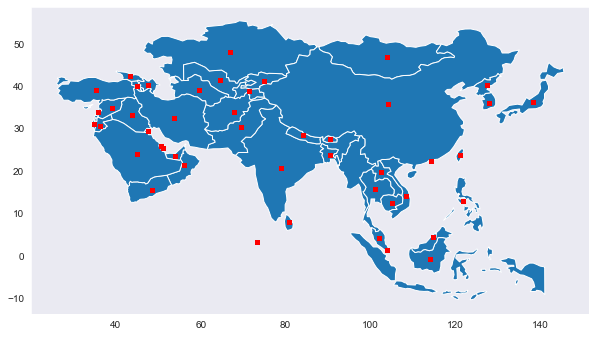

In [44]:
df2_asia = df2[df2['continent'] == 'Asia']

geometry = [Point(xy) for xy in zip(df2_asia['longitude'], df2_asia['latitude'])]
gdf = GeoDataFrame(df2_asia[['longitude', 'latitude']], geometry=geometry)

asia = world[world['continent'] == 'Asia']
gdf.plot(ax=asia.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [45]:
# Check percent missing by variable
num_rows = len(df_asia['date'])
for var in df_asia.columns:
    missing = df_asia[var].isna().sum()
    if missing > 0:
        print(var, '{}%'.format(round(missing/num_rows*100, 1)))

new_cases_smoothed 6.4%
new_deaths_smoothed 6.4%
reproduction_rate 33.9%
icu_patients 94.9%
hosp_patients 96.0%
new_tests_smoothed 61.2%
positive_rate 64.5%
tests_units 60.5%
people_vaccinated 75.0%
new_people_vaccinated_smoothed 44.4%
total_boosters 86.9%
new_vaccinations_smoothed 44.3%
stringency_index 26.4%
population_density 4.9%
median_age 1.0%
aged_70_older 1.0%
gdp_per_capita 6.9%
extreme_poverty 44.0%
cardiovasc_death_rate 4.0%
diabetes_prevalence 6.1%
female_smokers 24.0%
male_smokers 24.0%
handwashing_facilities 48.0%
hospital_beds_per_thousand 10.0%
life_expectancy 1.0%
human_development_index 6.1%


In [83]:
# Check percent missing by country
for country in df_asia['location'].unique():
    mask = df_asia['location'] == country
    num_cells = len(df_asia[mask]) * 30
    missing = df_asia[mask].isna().sum().sum()
    percent = round(missing/num_cells*100, 1)
    if percent > 40:
        print(country, '{}%'.format(percent))

In [51]:
# Based on above, drop
    # Country: Northern Cyprus, Hong Kong, and Macao (maybe North Korea too)
    # Variable: icu_patients, hosp_patients, and total_boosters (maybe positive_rate, new_tests_smoothed, and test_units too)

# Drop countries
mask = (df_asia['location'] == 'Northern Cyprus') | (df_asia['location'] == 'Hong Kong') | (df_asia['location'] == 'Macao')
df_asia = df_asia[~mask]
    
# Drop variables
col_to_drop = ['icu_patients', 'hosp_patients', 'new_tests_smoothed', 'positive_rate', 'tests_units',
              'new_people_vaccinated_smoothed', 'total_boosters', 'extreme_poverty', 'handwashing_facilities']
df_asia = df_asia.drop(col_to_drop, axis=1)

In [52]:
# Recheck missing values be variable
num_rows = len(df_asia['date'])
for var in df_asia.columns:
    missing = df_asia[var].isna().sum()
    if missing > 0:
        print(var, '{}%'.format(round(missing/num_rows*100, 1)))

new_cases_smoothed 2.5%
new_deaths_smoothed 2.4%
reproduction_rate 31.1%
people_vaccinated 76.0%
new_vaccinations_smoothed 45.6%
stringency_index 25.9%
population_density 4.1%
gdp_per_capita 6.2%
diabetes_prevalence 4.1%
female_smokers 20.8%
male_smokers 20.8%
hospital_beds_per_thousand 6.2%
human_development_index 4.1%


In [53]:
# Recheck missing values by country
for country in df_asia['location'].unique():
    mask = df_asia['location'] == country
    num_cells = len(df_asia[mask]) * 30
    missing = df_asia[mask].isna().sum().sum()
    percent = round(missing/num_cells*100, 1)
    if percent > 20:
        print(country, '{}%'.format(percent))

North Korea 26.7%
Syria 23.1%
Taiwan 34.4%


| Variable | How to Handel missing values | 
|:---|:--|
| `new_cases_smoothed` | Input 0.  NaN only entered when negative values present due to corrective reporting. | 
| `new_deaths_smoothed` | Input 0. NaN only entered when negative values present due to corrective reporting. | 
| `reproduction_rate` | Backward fill by country. | 
| `people_vaccinated` | Forward fill for missing values after vaccine released by country. | 
| `new_vaccinations_smoothed` | Input 0. Missing values prior to vaccine release date are 0. Assume no new vaccinations or reporting error for NaN values after vaccine date. | 
| `stringency_index` | By country, forward fill. Assuming a missing value means it was not reported and no change between previous assigned value. | 
| `population_density` | By country, fill with average value.  If country missing all values, see if can research and input. |
| `gdp_per_capita` | Fill with average. | 
| `diabetes_prevalence` | Fill with average. |
| `female_smokers` | Fill with average. |
| `male_smokers` | Fill with average. | 
| `hospital_beds_per_thousand` | Fill with average. | 
| `human_development_index` | Fill with average. | 

In [54]:
# Input 0 for assigned columns
fill_values = {'new_cases_smoothed' : 0, 'new_deaths_smoothed':0, 'new_vaccinations_smoothed':0}
df_asia.fillna(fill_values, inplace=True)

In [55]:
# Reproduction Rate - Back Fill by country -- forward fill the last
for country in df_asia['location'].unique():
    mask = df_asia['location'] == country
    df_asia.loc[mask, 'reproduction_rate'] = df_asia.loc[mask, 'reproduction_rate'].bfill().ffill()

In [56]:
# Check for still missing
df_asia['reproduction_rate'].isna().sum()

2770

In [57]:
# Countries where variable never reported:
df_asia[df_asia['reproduction_rate'].isna()]['location'].unique()

array(['North Korea', 'Turkmenistan'], dtype=object)

In [58]:
# When aggregate to single data row per day for continent, will take average. 
# For contries where reproduction rate never reported -- take average for given date of continent and input

for date in df_asia['date'].unique():
    avg = np.mean(df_asia[df_asia['date'] == date]['reproduction_rate'])
    for country in df_asia[df_asia['reproduction_rate'].isna()]['location'].unique():
        mask = (df_asia['location'] == country) & (df_asia['date'] == date)
        df_asia.loc[mask, 'reproduction_rate'] = avg

In [59]:
df_asia['reproduction_rate'].isna().sum()

0

In [60]:
# People Vaccinated -- Forward fill by country (start with 0)

for country in df_asia['location'].unique():
    mask = df_asia['location'] == country
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].ffill()
    
    # check if never reported for each country
    date_last_null = df_asia.loc[(mask) & (df_asia['people_vaccinated'].isna()), 'date'][-1:]
    if date_last_null.item() < df_asia[mask]['date'].max():
        df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].fillna(0)
    else:
        print(country, 'never reported on number of people vaccinated.')

North Korea never reported on number of people vaccinated.


In [61]:
# Going to move forward with inputting 0 for all of North Korea values for people vaccinated
    # This will artificially deflate the variable by a small amount, but seeing as North Korea did 
    # not start vaccinating people until the summer of 2022, and we cannot reasonably take a mean nor
    # median do to varying sizes in country population, this is the best solution
    
df_asia['people_vaccinated'].fillna(0, inplace=True)

In [84]:
# stringency_index
df_asia['stringency_index'].isna().sum()

0

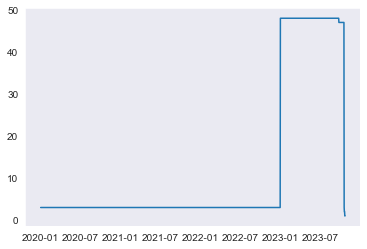

In [63]:
y = []
for date in df_asia['date'].unique():
    y.append(df_asia[df_asia['date'] == date]['stringency_index'].isna().sum())
    
plt.plot(df_asia['date'].unique(), y)
plt.set_title('Number of Missing Values')
plt.;

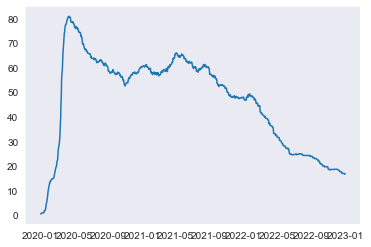

In [64]:
y = []
for date in df_asia['date'].unique():
    avg = np.mean(df_asia[df_asia['date'] == date]['stringency_index'])
    y.append(avg)
    
plt.plot(df_asia['date'].unique(), y);

In [65]:
# While realistically, when this stopped being reported in 2023, most contries dropped all Covid-19 restrictions
    # which would drop this stringency index down to zero, we will move forward with forward filling nulls
    # and taking an average per day for countries that did not report (since this value will be averaged when
    # taking aggregate for the continent)
    
for country in df_asia['location'].unique():
    mask = df_asia['location'] == country
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].ffill()

In [66]:
df_asia['stringency_index'].isna().sum()

4155

In [67]:
# Countries that never reported stringency index:
df_asia[df_asia['stringency_index'].isna()]['location'].unique()

array(['Armenia', 'Maldives', 'North Korea'], dtype=object)

In [68]:
# For the countries that never reported we will put the average for the day in -- this value will be averaged in aggregate
for date in df_asia['date'].unique():
    avg = np.mean(df_asia[df_asia['date'] == date]['stringency_index'])
    for country in df_asia[df_asia['stringency_index'].isna()]['location'].unique():
        mask = (df_asia['location'] == country) & (df_asia['date'] == date)
        df_asia.loc[mask, 'stringency_index'] = avg

In [69]:
df_asia['stringency_index'].isna().sum()

0

In [70]:
# Population Density
df_asia[df_asia['population_density'].isna()]['location'].unique()

array(['Syria', 'Taiwan'], dtype=object)

In [71]:
# Syria - 113 in 2020 -- use for all
    # https://worldpopulationreview.com/countries/syria-population
mask = df_asia['location'] == 'Syria'    
df_asia.loc[mask, 'population_density'] = df_asia.loc[mask, 'population_density'].fillna(113)

# Taiwan - 673
    # https://worldpopulationreview.com/countries/taiwan-population
mask = df_asia['location'] == 'Taiwan'    
df_asia.loc[mask, 'population_density'] = df_asia.loc[mask, 'population_density'].fillna(673)

In [72]:
df_asia['population_density'].isna().sum()

0

In [81]:
# For static numbers for country, fill missing countries with continent average
fill_avg = ['gdp_per_capita', 'diabetes_prevalence', 'female_smokers', 
            'male_smokers', 'hospital_beds_per_thousand', 'human_development_index']

for var in fill_avg:
    df_asia.loc[:, var] = df_asia.loc[:, var].fillna(np.mean(df_asia[var]))

For Each Zone:
- Graph -- note date of vaccine release??
    - number of deaths against time
    - number of cases against time
    - number of recoveries against time
- ACF and PACFf
- Seasonality?

# Modeling

- Baseline --> naive forecasting (data shifted by one time-step)
- ARIMA and/or SARIMA
- grid search/pmdarima.auto_arima (?) 

## Basline  

- One shift

## Model 2

## Model 3

## All Model Comparison

# Final Model Evaluation

# Conclusion + Recommendations